In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import pickle

In [2]:
england_gdf = gpd.read_file('GBR_adm/GBR_adm0.shp')
england_gdf

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,242,GBR,United Kingdom,82,GBR,United Kingdom,UNITED KINGDOM,United Kingdom,United Kingdom,None,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-6.38792 49.86875, -6.38792 49..."


/var/folders/j0/xlywy25x2dz586vnrkqf8ppc0000gn/T/ipykernel_19583/585896352.py:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in england_gdf['geometry'][0]:


Mainland at polygon 815 


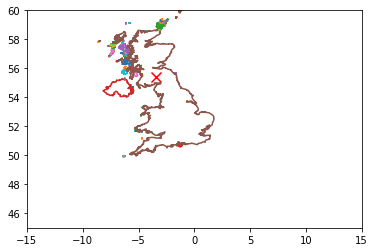

In [3]:
#usaCenter = Point(-98.35,39.50)
ukCenter = Point(-3.44,55.38)

idx = 0
for polygon in england_gdf['geometry'][0]:
    x,y = polygon.exterior.xy
    plt.plot(x,y)
    if ukCenter.within(polygon):
        ukPoly = np.array([(yi,xi) for xi,yi in zip(x,y)])
        print("Mainland at polygon {} ".format(idx))
    idx+=1
plt.scatter([-3.44], [55.38], c='r', marker='x', s=100)
plt.xlim([-15,15])
plt.ylim([45,60])

plt.show()

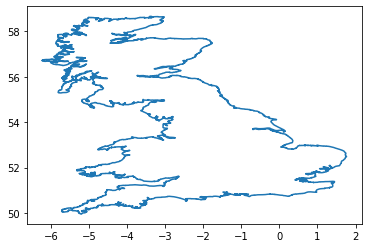

array([[55.72986221, -4.88527679],
       [55.72958374, -4.88527679],
       [55.72958374, -4.8836112 ],
       ...,
       [55.72874832, -4.88583279],
       [55.72986221, -4.88583279],
       [55.72986221, -4.88527679]])

In [4]:
plt.plot(ukPoly[:,1],ukPoly[:,0])
plt.show()
ukPoly

In [5]:
pickle.dump(ukPoly,open("ukPoly.pkl","wb"))

In [6]:
import shapely
import gmaps
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle

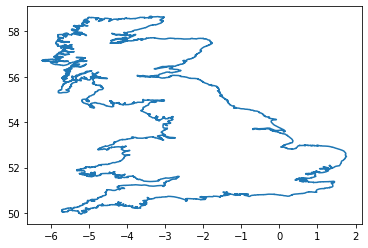

In [7]:
ukPoly = pickle.load(open("ukPoly.pkl",'rb'))
ukPoly = Polygon(np.flip(ukPoly))
x,y = ukPoly.exterior.xy
plt.plot(x,y)

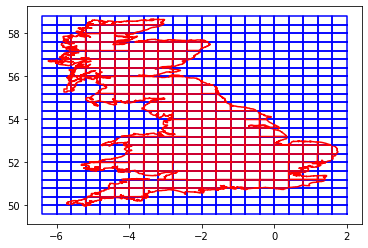

In [8]:
dim = 0.4
bounds = ukPoly.bounds
xmin = int(bounds[0] // dim)
xmax = int(bounds[2] // dim)
ymin = int(bounds[1] // dim)
ymax = int(bounds[3] // dim)
for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
        b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
        g = ukPoly.intersection(b)
        x,y = b.exterior.xy
        plt.plot(x,y,c='b')
        if g.is_empty:
            continue
        if type(g)==shapely.geometry.multipolygon.MultiPolygon:
            for gems in g.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='r')
        else:
            x,y = g.exterior.xy
            plt.plot(x,y,c='r')
plt.show()

In [9]:
def partition(polygon, dim, mergeFactor=0.1):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    bounds = polygon.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = polygon.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor=0.1):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(polyGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
#     fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

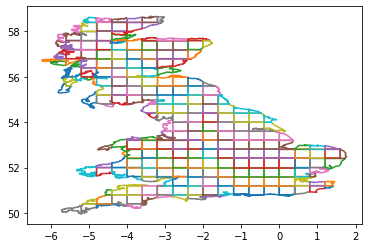

246

In [11]:
for i in ukPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()
len(ukPolyGrid)

In [12]:
pickle.dump(ukPolyGrid,open("ukPolyGrid.pkl","wb"))